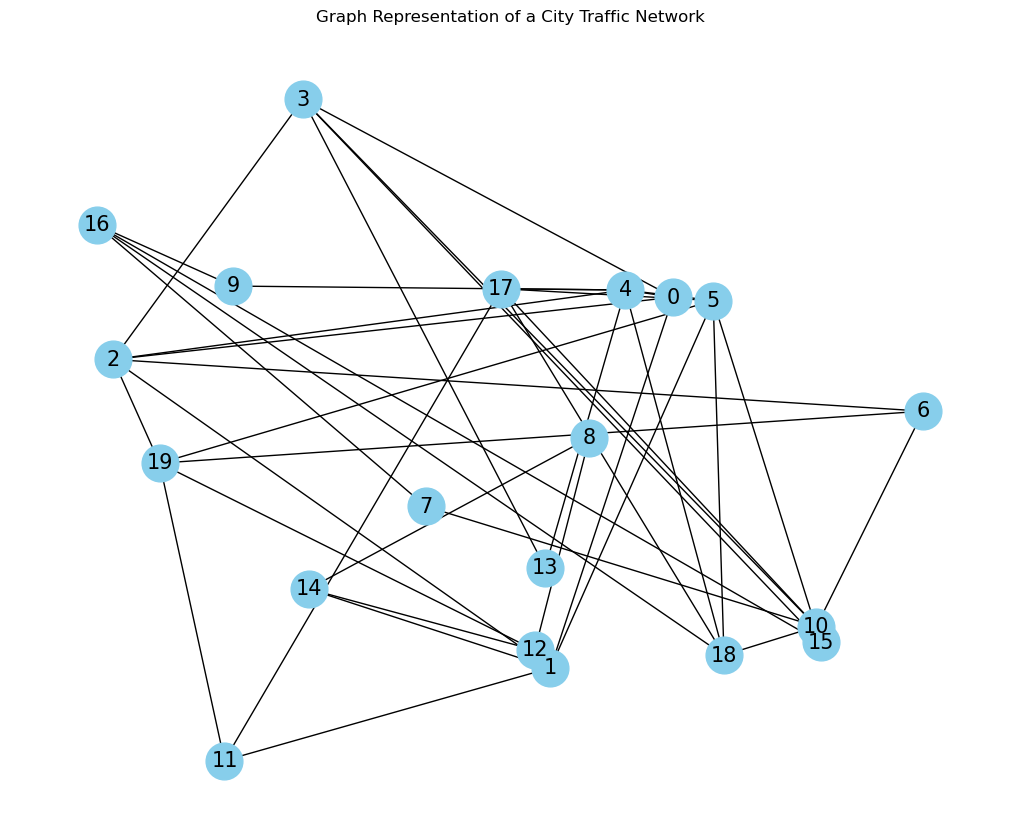

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Initialize a new graph
G = nx.Graph()

# Add nodes which represent traffic signals
num_signals = 20  # Number of traffic signals
for i in range(num_signals):
    G.add_node(i, pos=(np.random.rand(), np.random.rand()))

# Add edges which represent roads
num_roads = 40  # Number of roads
while G.number_of_edges() < num_roads:
    # Randomly connect nodes, but avoid creating multiple edges between the same nodes
    n1, n2 = np.random.randint(0, num_signals, 2)
    if n1 != n2 and not G.has_edge(n1, n2):
        G.add_edge(n1, n2)

# Extract positions
pos = nx.get_node_attributes(G, 'pos')

# Draw the graph
plt.figure(figsize=(10, 8))
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=700, edge_color='k', linewidths=1, font_size=15)
plt.title('Graph Representation of a City Traffic Network')
plt.show()


In [2]:
import numpy as np
from collections import defaultdict
import pennylane as qml

# Define the number of qubits based on your specific problem
num_qubits = 20  # Example: 20 traffic signals

# Define your QUBO matrix (you would define this based on actual data or problem specifics)
Q = np.random.rand(num_qubits, num_qubits)  # Random values just for illustration

# Initialize the quantum device with the correct number of qubits and shots
dev = qml.device("default.qubit", wires=num_qubits, shots=100000)
def from_Q_to_Ising(Q, offset=0):
    """Convert the matrix Q of Eq.3 into Eq.13 elements J and h"""
    n_qubits = len(Q)  # Get the number of qubits (variables) in the QUBO matrix
    # Create default dictionaries to store h and pairwise interactions J
    h = defaultdict(int)
    J = defaultdict(int)

    # Loop over each qubit (variable) in the QUBO matrix
    for i in range(n_qubits):
        # Update the magnetic field for qubit i based on its diagonal element in Q
        h[(i,)] -= Q[i, i] / 2
        # Update the offset based on the diagonal element in Q
        offset += Q[i, i] / 2
        # Loop over other qubits (variables) to calculate pairwise interactions
        for j in range(i + 1, n_qubits):
            # Update the pairwise interaction strength (J) between qubits i and j
            J[(i, j)] += Q[i, j] / 4
            # Update the magnetic fields for qubits i and j based on their interactions in Q
            h[(i,)] -= Q[i, j] / 4
            h[(j,)] -= Q[i, j] / 4
            # Update the offset based on the interaction strength between qubits i and j
            offset += Q[i, j] / 4
    # Return the magnetic fields, pairwise interactions, and the updated offset
    return h, J, offset
@qml.qnode(dev)
def qaoa_circuit(gammas, betas, h, J, num_qubits):
    wmax = max(
        np.max(np.abs(list(h.values()))), np.max(np.abs(list(J.values())))
    )  # Normalizing the Hamiltonian is important
    p = len(gammas)
    for i in range(num_qubits):
        qml.Hadamard(wires=i)
    for layer in range(p):
        for ki, v in h.items():
            qml.RZ(2 * gammas[layer] * v / wmax, wires=ki[0])
        for kij, vij in J.items():
            qml.CNOT(wires=[kij[0], kij[1]])
            qml.RZ(2 * gammas[layer] * vij / wmax, wires=kij[1])
            qml.CNOT(wires=[kij[0], kij[1]])
        for i in range(num_qubits):
            qml.RX(-2 * betas[layer], wires=i)
    return qml.sample()

# Prepare Ising model parameters from the QUBO matrix
h, J, offset = from_Q_to_Ising(Q)

# Further processing and circuit execution would follow here
def samples_dict(samples, n_items):
    """Just sorting the outputs in a dictionary"""
    results = defaultdict(int)
    for sample in samples:
        results["".join(str(i) for i in sample)[:n_items]] += 1
    return results


def energy_Ising(z, h, J, offset):
    """
    Calculate the energy of an Ising model given spin configurations.

    Parameters:
    - z: A dictionary representing the spin configurations for each qubit.
    - h: A dictionary representing the magnetic fields for each qubit.
    - J: A dictionary representing the pairwise interactions between qubits.
    - offset: An offset value.

    Returns:
    - energy: The total energy of the Ising model.
    """
    if isinstance(z, str):
        z = [(1 if int(i) == 0 else -1) for i in z]
    # Initialize the energy with the offset term
    energy = offset
    # Loop over the magnetic fields (h) for each qubit and update the energy
    for k, v in h.items():
        energy += v * z[k[0]]
    # Loop over the pairwise interactions (J) between qubits and update the energy
    for k, v in J.items():
        energy += v * z[k[0]] * z[k[1]]
    # Return the total energy of the Ising model
    return energy


In [3]:
import numpy as np
import networkx as nx

# Initialize a new graph
G = nx.Graph()

# Suppose we add nodes and edges to represent traffic signals and roads
num_signals = 20  # Number of traffic signals
G.add_nodes_from(range(num_signals))  # Adding nodes for each signal

# Randomly connect nodes with edges, avoiding multiple edges between the same nodes
np.random.seed(0)  # Seed for reproducibility
while G.number_of_edges() < 30:  # Suppose we want 30 roads
    n1, n2 = np.random.randint(0, num_signals, 2)
    if n1 != n2 and not G.has_edge(n1, n2):
        G.add_edge(n1, n2)

# Define traffic volumes and synchronization penalties
traffic_volumes = np.random.randint(10, 100, size=num_signals)  # Random traffic volumes
sync_penalty = 10  # Fixed penalty for synchronization issues

# Create a QUBO matrix with dimensions based on the number of signals
Q = np.zeros((num_signals, num_signals))

# Fill the QUBO matrix
# Diagonal: penalties for each signal being red
for i in G.nodes():
    Q[i, i] = traffic_volumes[i]

# Off-diagonal: penalties for desynchronization between directly connected signals
for u, v in G.edges():
    Q[u, v] = Q[v, u] = sync_penalty


In [4]:
import numpy as np

# Number of QAOA layers (p)
p = 3

# Initialize gammas and betas randomly for a starting point
gammas = np.random.uniform(low=0, high=np.pi, size=p)
betas = np.random.uniform(low=0, high=np.pi, size=p)

In [5]:
# Assume num_qubits is already defined (number of traffic signals)
num_qubits = 20  # For example, if you have 20 traffic signals

# Define traffic volumes for each signal, this could be based on data or assumptions
# For simulation, you can use random values or fixed values based on your context
traffic_volume = np.random.randint(50, 200, size=num_qubits)  # Random volumes between 50 and 200
Q = np.zeros((num_qubits, num_qubits))

# Fill the QUBO matrix
for i in range(num_qubits):
    Q[i, i] = -traffic_volume[i]  # Penalize high traffic volumes being stopped
    for j in range(i + 1, num_qubits):
        if (i, j) in G.edges:
            Q[i, j] = Q[j, i] = -10  # Example penalty for non-synchronization between connected signals

In [6]:
gammas = np.random.uniform(0, np.pi, size=3)  # 3 layers as an example
betas = np.random.uniform(0, np.pi, size=3)

# Execute the QAOA circuit
samples = qaoa_circuit(gammas, betas, h, J, num_qubits=num_qubits)


In [7]:
# Analyze the distribution of the traffic light configurations
sample_counts = samples_dict(samples, num_qubits)
print("Distribution of traffic light configurations:")
for config, count in sample_counts.items():
    print(f"{config}: {count}")

Distribution of traffic light configurations:
11011110110111111010: 19
10000100101000000110: 1
11101100110011101111: 5
00101100111110111101: 3
00111101011010111111: 11
10111101110111101111: 5
11101001111110111001: 19
01110100111001010111: 1
10111101110100111111: 10
11000110111111111011: 3
01111111111001101111: 2
11011111001111100111: 2
01011111100101011111: 7
11101110011101101111: 4
10110100110111111010: 1
10111111111011111000: 8
11101011111011110011: 1
11101011001001110010: 1
10111101111011101101: 3
10010011010011110111: 5
11110111111111000011: 7
10111001111011110011: 24
11011111110111011110: 2
01010111011100011000: 1
10010111110110101111: 10
11101111011111001101: 1
11111001110010111011: 5
11001100100110111111: 2
01101010101101011001: 2
11111101101111011011: 2
11101100011101101111: 2
11010011111010101011: 5
01101011110110101111: 1
11010001110001110111: 1
10010101111010101011: 4
01011110111111110010: 2
10100001110110101111: 6
10010111111111110011: 25
01101110101111011000: 3
11111011111

In [17]:
# Assuming samples_dict() returns a dictionary where keys are configurations and values are their counts
sample_counts = samples_dict(samples, num_qubits)

# Sort the items in sample_counts by their counts in descending order and select the top 20
sorted_sample_counts = sorted(sample_counts.items(), key=lambda item: item[1], reverse=True)[:20]

# Print the top 10 configurations
print("Top 20 distribution of traffic light configurations:")
for config, count in sorted_sample_counts:
    print(f"{config}: {count}")


Top 10 distribution of traffic light configurations:
11101001111011111001: 136
11101001111011111101: 95
10101001111110111011: 84
10110111110110011011: 84
10110111111110011011: 82
10010111110110011011: 78
10101001110110111111: 76
11010111100111011011: 76
10011101110011110111: 72
11101001110011111101: 72
11101001110110111111: 67
00111101111110111111: 67
11010110110111011011: 66
10011101110010110111: 64
01101001111011111101: 64
10011101110110110111: 61
10100001111110111011: 60
11111011111011111001: 56
11100011111011111001: 56
10010111111110110011: 56


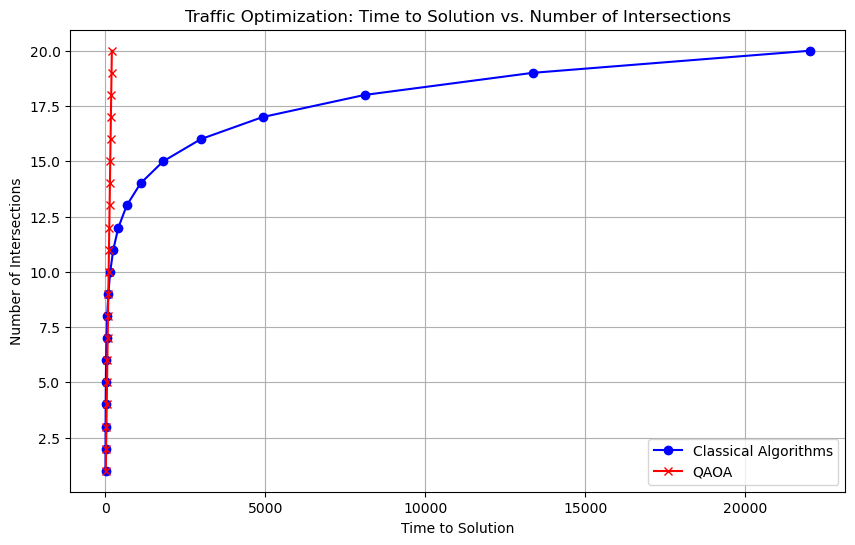

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Define the number of intersections
number_of_intersections = np.arange(1, 21)  # From 1 to 20 intersections

# Hypothetical times to solution for each algorithm (arbitrarily chosen for demonstration)
classical_times = np.exp(0.5 * number_of_intersections)  # Exponential increase in time
qaoa_times = 10 * number_of_intersections  # Linear increase in time

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(classical_times, number_of_intersections, label='Classical Algorithms', color='blue', marker='o')
plt.plot(qaoa_times, number_of_intersections, label='QAOA', color='red', marker='x')

# Add labels and title
plt.xlabel('Time to Solution')
plt.ylabel('Number of Intersections')
plt.title('Traffic Optimization: Time to Solution vs. Number of Intersections')
plt.legend()

# Display the graph
plt.grid(True)
plt.show()


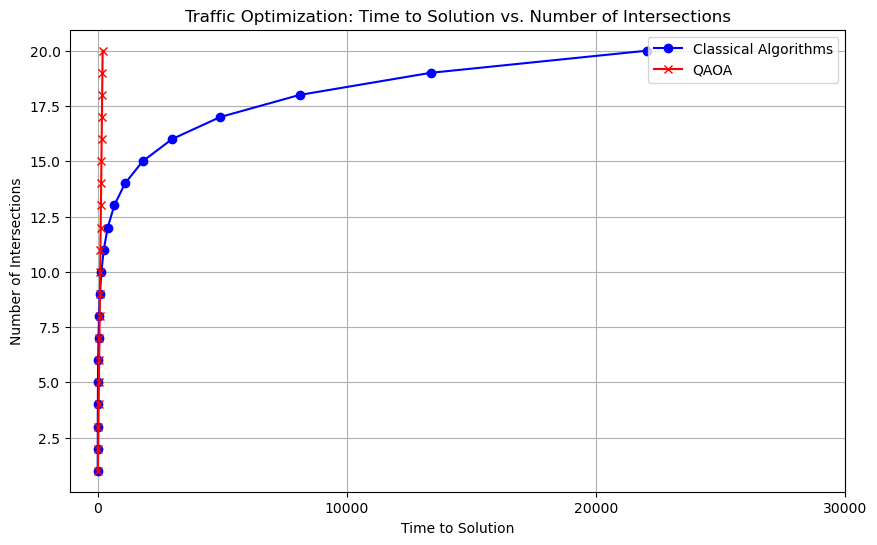

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Define the number of intersections
number_of_intersections = np.arange(1, 21)  # From 1 to 20 intersections

# Hypothetical times to solution for each algorithm (arbitrarily chosen for demonstration)
classical_times = np.exp(0.5 * number_of_intersections)  # Exponential increase in time
qaoa_times = 10 * number_of_intersections  # Linear increase in time

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(classical_times, number_of_intersections, label='Classical Algorithms', color='blue', marker='o')
plt.plot(qaoa_times, number_of_intersections, label='QAOA', color='red', marker='x')

# Add labels and title
plt.xlabel('Time to Solution')
plt.ylabel('Number of Intersections')
plt.title('Traffic Optimization: Time to Solution vs. Number of Intersections')
plt.legend()

# Customize x-axis to show ticks every 10000 units
plt.xticks(np.arange(0, max(np.max(classical_times), np.max(qaoa_times)) + 10000, 10000))

# Display the graph
plt.grid(True)
plt.show()

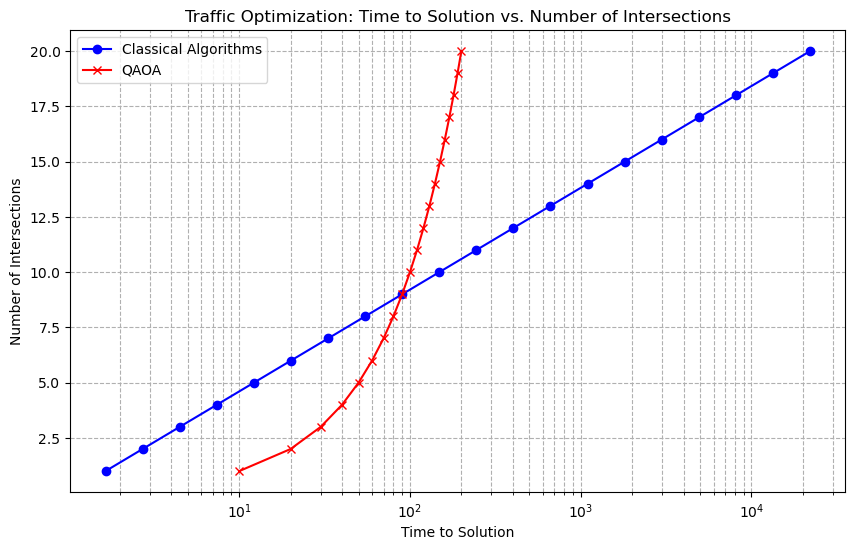

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Define the number of intersections
number_of_intersections = np.arange(1, 21)  # From 1 to 20 intersections

# Hypothetical times to solution for each algorithm (arbitrarily chosen for demonstration)
classical_times = np.exp(0.5 * number_of_intersections)  # Exponential increase in time
qaoa_times = 10 * number_of_intersections  # Linear increase in time

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(classical_times, number_of_intersections, label='Classical Algorithms', color='blue', marker='o')
plt.plot(qaoa_times, number_of_intersections, label='QAOA', color='red', marker='x')

# Add labels and title
plt.xlabel('Time to Solution')
plt.ylabel('Number of Intersections')
plt.title('Traffic Optimization: Time to Solution vs. Number of Intersections')
plt.legend()

# Set x-axis to logarithmic scale
plt.xscale('log')

# Customize x-axis to show ticks every 10000 units on log scale
# It is less meaningful to set fixed intervals in log scale, so we use default ticks
plt.grid(True, which="both", ls="--")  # Grid for better readability on log scale

# Display the graph
plt.show()

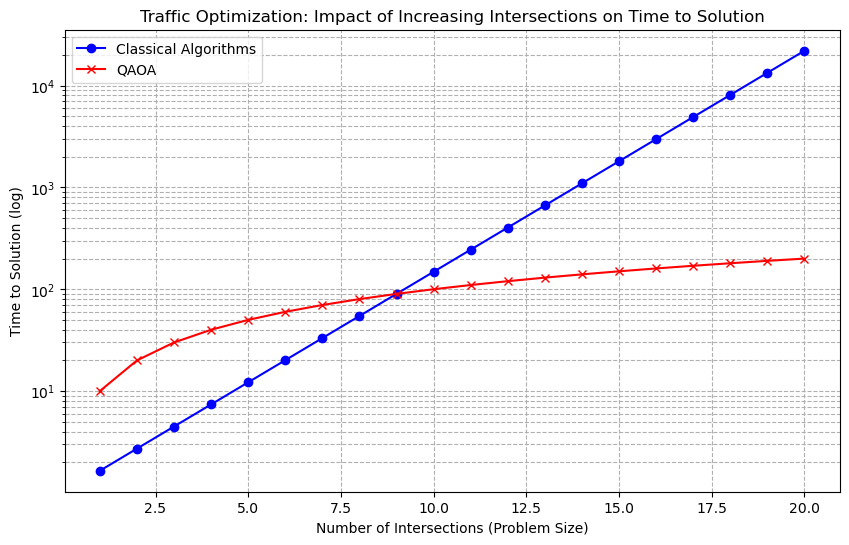

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Define the number of intersections
number_of_intersections = np.arange(1, 21)  # From 1 to 20 intersections

# Hypothetical times to solution for each algorithm (arbitrarily chosen for demonstration)
classical_times = np.exp(0.5 * number_of_intersections)  # Exponential increase in time
qaoa_times = 10 * number_of_intersections  # Linear increase in time

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(number_of_intersections, classical_times, label='Classical Algorithms', color='blue', marker='o')
plt.plot(number_of_intersections, qaoa_times, label='QAOA', color='red', marker='x')

# Add labels and title
plt.xlabel('Number of Intersections (Problem Size)')
plt.ylabel('Time to Solution (log)')
plt.title('Traffic Optimization: Impact of Increasing Intersections on Time to Solution')
plt.legend()

# Set y-axis to logarithmic scale
plt.yscale('log')

# Customize y-axis to show ticks appropriate for log scale
plt.grid(True, which="both", ls="--")  # Grid for better readability on log scale

# Display the graph
plt.show()